<a href="https://colab.research.google.com/github/maciejskorski/ml_examples/blob/master/RenyiEntropyEstimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Renyi Entropy Estimation

This project implements the sample-optimal adaptive Renyi entropy estimator.

## Adaptive Estimators

In [43]:
from scipy.special import binom
from collections import Counter
from scipy.stats import zipfian
import numpy as np
np.random.seed(12345)

K = 10000
p = zipfian(a=2,n=K)
xs = np.arange(1,K+1)
p2 = p.pmf(np.arange(1,K+1))**2
p_col = p2.sum()
p_col.round(5)

0.40005

In [28]:
import seaborn as sns

n = 20000
samples = p.rvs(size=n)

In [27]:
N(0.05/np.log2(K),1,0.5)

8504

In [44]:
import numpy as np
from scipy.special import binom
from collections import Counter

def estimate_collision(x,d=2):
  cnt = Counter(samples).values()
  cnt = np.array(list(cnt))
  return binom(cnt,d).sum()/binom(cnt.sum(),d)

estimate_collision(samples)

0.3989843742187109

In [34]:
C = lambda delta: 8/delta**2
N = lambda delta,Q,eps: round( 8*2**2*8*np.log(1/delta)*Q**(-1/2)*eps**(-2) )

delta = 0.05
eps = 0.5

def estimate_collision_adaptive(x,d=2,delta=delta,eps=eps):
  Q = 1
  for _ in range(3):
    n_subsample = N(delta/np.log2(K),Q,eps)
    subsample = x[:n_subsample]
    col_estimate = estimate_collision(subsample)
    print(n_subsample,col_estimate,Q)
    Q = Q/2

estimate_collision_adaptive(samples)

5717 0.3989843742187109 1
8084 0.3989843742187109 0.5
11433 0.3989843742187109 0.25


In [42]:
N(0.05,0.25/2,0.5)

8677

# Dataset

We use U.S. births data from 2000 to 2014, as provided by the Social Security Administration. The [dataset is available at GitHub](https://github.com/fivethirtyeight/data/tree/master/births).

In [87]:
import pandas as pd

!curl -o birthdays.csv https://www.panix.com/~murphy/bdata.txt # downloiad data
df = pd.read_csv('birthdays.csv',sep=' ') # read as dataframe
df = df[:-1] # skip control row
df['date'] = pd.to_datetime('2000'+df['date']) # convert dates
df.rename({'count':'births'},axis='columns',inplace=1)
df.head()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4049  100  4049    0     0   7470      0 --:--:-- --:--:-- --:--:--  7456


,date,births
0,2000-01-01,1482
1,2000-01-02,1213
2,2000-01-03,1220
3,2000-01-04,1319
4,2000-01-05,1262


In [88]:
birthdays = df.groupby(df['date'].dt.month_name())['births'].sum()
birthdays

date
April        37641
August       42980
December     40320
February     36753
January      40255
July         42148
June         38789
March        39940
May          39288
November     38940
October      41874
September    42112
Name: births, dtype: int64

In [75]:
import pandas as pd
host = 'raw.github.com'
user = 'fivethirtyeight'
repo = 'data'
branch = 'master'
file = 'births/US_births_2000-2014_SSA.csv'
url = f'https://{host}/{user}/{repo}/{branch}/{file}'
df = pd.read_csv(url,sep=',',header=0)
df['date'] = df[['year','month','date_of_month']].astype(str).apply('-'.join,axis=1)
df['date'] = pd.to_datetime(df['date'])
df = df[['date','births']]
df.head()

,date,births
0,2000-01-01,9083
1,2000-01-02,8006
2,2000-01-03,11363
3,2000-01-04,13032
4,2000-01-05,12558


In [76]:
birthdays = df.groupby([df['date'].dt.day_of_week,df['date'].dt.day_name()])['births'].sum()
birthdays = birthdays.droplevel(0,'index')

# Birthday Inference

Birthday on same day probability 0.14794
Collision probability of a distribution uniform over 7 elements is 	0.14286


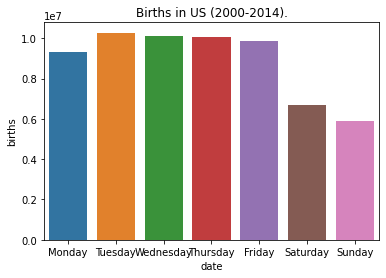

In [77]:
import numpy as np
from scipy.special import binom
import seaborn as sns
import matplotlib.pyplot as plt


p_col = binom(birthdays,2).sum()/binom(birthdays.sum(),2)
n = birthdays.sum()
m = len(birthdays)
gap_col = p_col-1/m

print('Birthday on same day probability {:.5f}'.format(p_col))
print('Collision probability of a distribution uniform over 7 elements is 	{:.5f}'.format(1/m))

fig,ax = plt.subplots()
sns.barplot(data=birthdays.reset_index(),x='date',y='births',ax=ax)
ax.set_title('Births in US (2000-2014).')
plt.show()

In [83]:
import sympy as sm

y,n,m,delta = sm.symbols('y,n,m,delta',positive=True)

def sigma(y,n,m):
  return sm.sqrt(4*(y/m+sm.sqrt(y)**(3))/n+2*(y+1/m)/(n*(n-1)))

sigma(y,n,m)

sqrt((4*y**(3/2) + 4*y/m)/n + (2*y + 2/m)/(n*(n - 1)))

In [84]:
from sympy import solve_univariate_inequality

subs = {n : birthdays.sum(), m : len(birthdays)}

sigma_subs = sigma(y,n,m).subs(subs)

solve_univariate_inequality(abs(y-gap_col) <= 10*sigma_subs, y)

(0.00499508345980237 <= y) & (y <= 0.00516234863382153)

In [86]:
round(0.00499508345980237,5)

0.005

In [17]:
from sympy import solve_poly_inequality, Poly, solve_univariate_inequality
from sympy.abc import x

solve_poly_inequality(Poly(x**(3) -x - 1, x, domain='ZZ'), '==')

AttributeError: ignored

In [26]:
solve_univariate_inequality(x**5-x+0.1 <= 0, x)

((0.100010005003503 <= x) & (x <= 0.973259535241842)) | ((x <= -1.02357714254444) & (-oo < x))

In [6]:
import numpy as np
from scipy.optimize import bisect

def sigma(y,m=m,n=birthdays.sum()):
  return np.sqrt(y/(m*n)+y**(3/2)/n+y/n**2+2/(m*n*(n-1)))

yr = bisect(lambda y:y+10*sigma(y)-y0,0,1)


NameError: ignored

In [182]:
birthdays.sum()

62187024

y0

0.00017420826034589276

In [132]:
y0 = p_col-1/m
y0

0.00017420826034589276

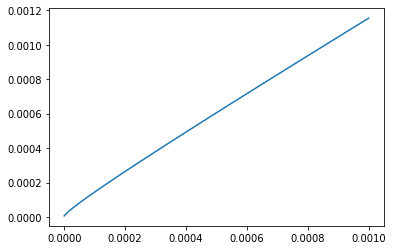

In [149]:
ys = np.linspace(0,0.001,100)

sns.lineplot(x=ys,y=ys+10*sigma(ys))

In [161]:
yr - 10*sigma(yr)

7.461345648388854e-05

In [60]:
def confidence_ub(gamma,m=12,n=n):
  return gamma+np.sqrt(4*gamma/(m*n)+4*gamma**1.5/n)


def confidence_lb(gamma,m=12,n=n):
  return gamma-np.sqrt(4*gamma/(m*n)+4*gamma**1.5/n)


confidence_ub(0.1423)

NameError: ignored

In [167]:
import sympy as sm

n = sm.symbols('n')

(1*sm.binomial(n-2,1)/sm.binomial(n,2)).combsimp()

4*(n - 2)/(n*(n - 1))